## Airbnb Price Prediction - Vienna with MLP
### Multi-Layer Perceptron Model for Price Prediction

The goal is to train this model to predict Airbnb listing prices.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # ← Import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# --- 1. Load Data ---
df = pd.read_csv('data/listings.csv')

# --- 2. Clean Target Variable ('price') ---
df['price'] = (
    df['price']
      .replace({'\\$':'', ',':''}, regex=True)
      .astype(float)
)
# Drop rows where the price is missing, as it's our target
df.dropna(subset=['price'], inplace=True)

# --- 3. Handle Outliers ---
# Filter out top 1% of prices to remove extreme outliers
price_cap = df['price'].quantile(0.99)
df = df[df['price'] < price_cap]

# Cap the 'minimum_nights' feature to a reasonable value
df['minimum_nights'] = df['minimum_nights'].clip(upper=365)


# --- 4. Engineer New Features ---
# Engineer date feature from 'last_review'
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days


# --- 5. Define Feature Lists ---
# We define the lists here so we can easily fill missing values below
numeric_cols = [
    'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365', 'days_since_last_review'
]

categorical_cols = [
    'neighbourhood', 'room_type', 'property_type'
]

amenities_col = 'amenities'
name_col = 'name'


# --- 6. Fill Missing Values for Specific Columns ---
# The numeric imputer in the pipeline will handle NaNs in numeric_cols.
# For others, we fill them explicitly here.
df[categorical_cols] = df[categorical_cols].fillna('missing')
df[amenities_col] = df[amenities_col].fillna('')
df[name_col] = df[name_col].fillna('')


# --- 7. Define Final X and y ---
X = df[numeric_cols + categorical_cols + [amenities_col, name_col]]
y = df['price']

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Cell 4: Log‐transform the target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)


In [6]:
# Define transformers for each column type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

amenities_transformer = Pipeline(steps=[
    ('vectorizer', CountVectorizer(token_pattern=r'(?u)\b\w\w+\b', max_features=100))
])

name_transformer = Pipeline(steps=[
    ('vectorizer', CountVectorizer(max_features=50))
])


# Create the preprocessor with the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('amenities', amenities_transformer, amenities_col),
        ('name', name_transformer, name_col)
    ],
    remainder='drop'
)

# Define the MLP Regressor model
mlp = MLPRegressor(
    hidden_layer_sizes=(150,100, 50),
    activation='relu',
    solver='adam',
    alpha=1,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-4,
    max_iter=500,
    random_state=42
)

# Create the final pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', mlp)
])

In [7]:
# --- 1. Fit the pipeline on the training data ---
pipe.fit(X_train, y_train_log)


# --- 2. Get predictions for both training and test sets ---
y_train_pred_log = pipe.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_test_pred_log) # Using y_pred to match original variable name


# --- 3. Calculate metrics for the TRAINING set ---
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


# --- 4. Calculate metrics for the TEST set ---
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)


# --- 5. Print the results for comparison ---
print("--- Training Set Metrics ---")
print(f"Mean Squared Error (MSE):       {train_mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${train_rmse:,.2f}")
print(f"R-squared (R²):                 {train_r2:.3f}\n")

print("--- Test Set Metrics ---")
print(f"Mean Squared Error (MSE):       {test_mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${test_rmse:,.2f}")
print(f"R-squared (R²):                 {test_r2:.3f}")

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Training Set Metrics ---
Mean Squared Error (MSE):       1,187.47
Root Mean Squared Error (RMSE): $34.46
R-squared (R²):                 0.716

--- Test Set Metrics ---
Mean Squared Error (MSE):       2,103.42
Root Mean Squared Error (RMSE): $45.86
R-squared (R²):                 0.495


In [8]:
# Cell 7: Predict and invert log‐transform
y_pred_log = pipe.predict(X_test)
y_pred     = np.expm1(y_pred_log)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
# Cell 8: Evaluate on original scale
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Model trained successfully!")
print(f"Test MAE: ${mae:,.2f}")

✅ Model trained successfully!
Test MAE: $26.38


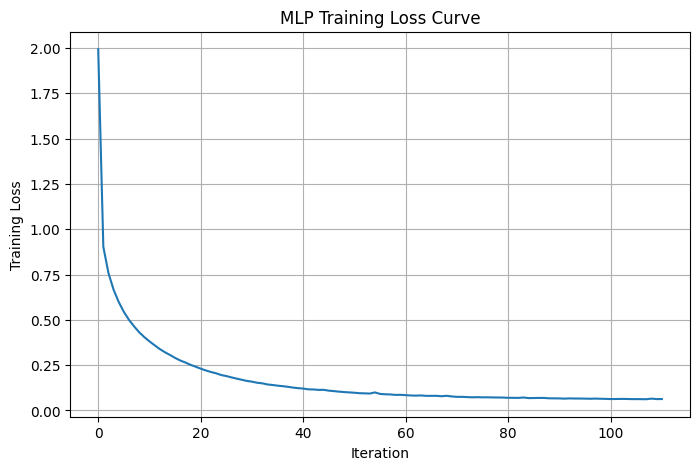

In [10]:
# Cell 9: Plot the training loss curve
loss_curve = pipe.named_steps['regressor'].loss_curve_
plt.figure(figsize=(8, 5))
plt.plot(loss_curve)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('MLP Training Loss Curve')
plt.grid(True)
plt.show()

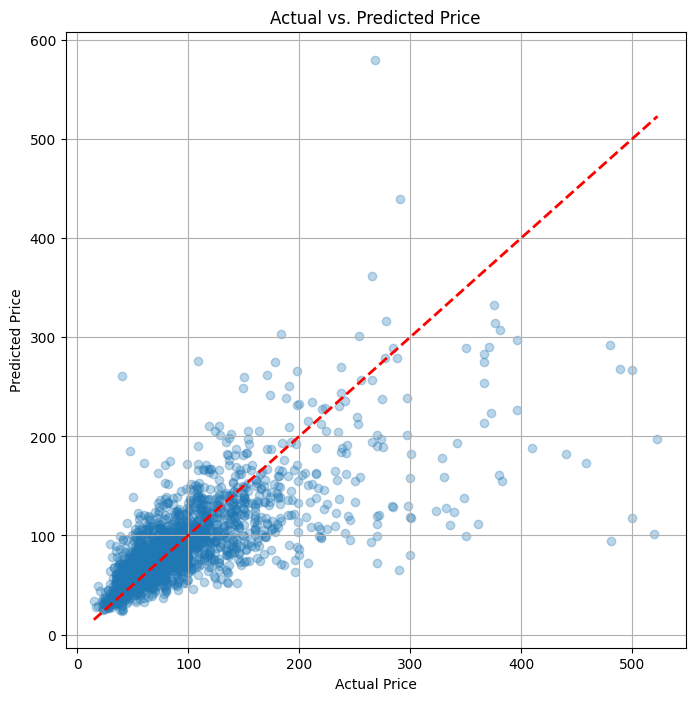

In [11]:
# Plot predicted vs. actual prices
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Get predictions for the TRAINING set ---
# The model has already been fitted, so we just predict
y_train_pred_log = pipe.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)

# --- 2. Calculate metrics for the TRAINING set ---
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# --- 3. Calculate metrics for the TEST set ---
# Note: y_pred for the test set was already calculated in a previous cell
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

# --- 4. Print the results for comparison ---
print("--- Training Set Metrics ---")
print(f"Mean Absolute Error (MAE):      ${train_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${train_rmse:,.2f}")
print(f"R-squared (R²):                 {train_r2:.3f}\n")

print("--- Test Set Metrics ---")
print(f"Mean Absolute Error (MAE):      ${test_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${test_rmse:,.2f}")
print(f"R-squared (R²):                 {test_r2:.3f}")

--- Training Set Metrics ---
Mean Absolute Error (MAE):      $19.24
Root Mean Squared Error (RMSE): $34.46
R-squared (R²):                 0.716

--- Test Set Metrics ---
Mean Absolute Error (MAE):      $26.38
Root Mean Squared Error (RMSE): $45.86
R-squared (R²):                 0.495


Training model with alpha = 0.0001...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 0.001...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 0.01...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 0.1...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 1...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 10...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training model with alpha = 100...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


...Done!


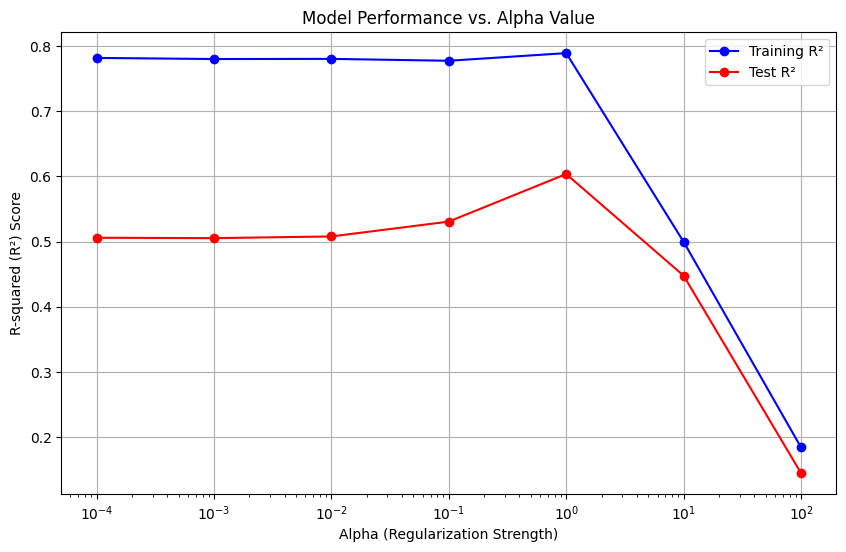

In [13]:
# Create a list of alpha values to test, ranging from weak to strong regularization
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Create empty lists to store the scores
train_scores = []
test_scores = []

# Loop through each alpha value
for alpha in alphas:
    print(f"Training model with alpha = {alpha}...")
    
    # Set the alpha parameter in the pipeline's regressor step
    pipe.set_params(regressor__alpha=alpha)
    
    # Fit the model
    pipe.fit(X_train, y_train_log)
    
    # Calculate R² score for the training and test sets and store them
    train_scores.append(pipe.score(X_train, y_train_log))
    test_scores.append(pipe.score(X_test, y_test_log))

print("...Done!")

# --- Plot the results ---
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_scores, 'bo-', label='Training R²')
plt.plot(alphas, test_scores, 'ro-', label='Test R²')
plt.xscale('log') # Use a logarithmic scale for the x-axis
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R-squared (R²) Score')
plt.title('Model Performance vs. Alpha Value')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Calculating permutation importance on transformed data...
...Done!


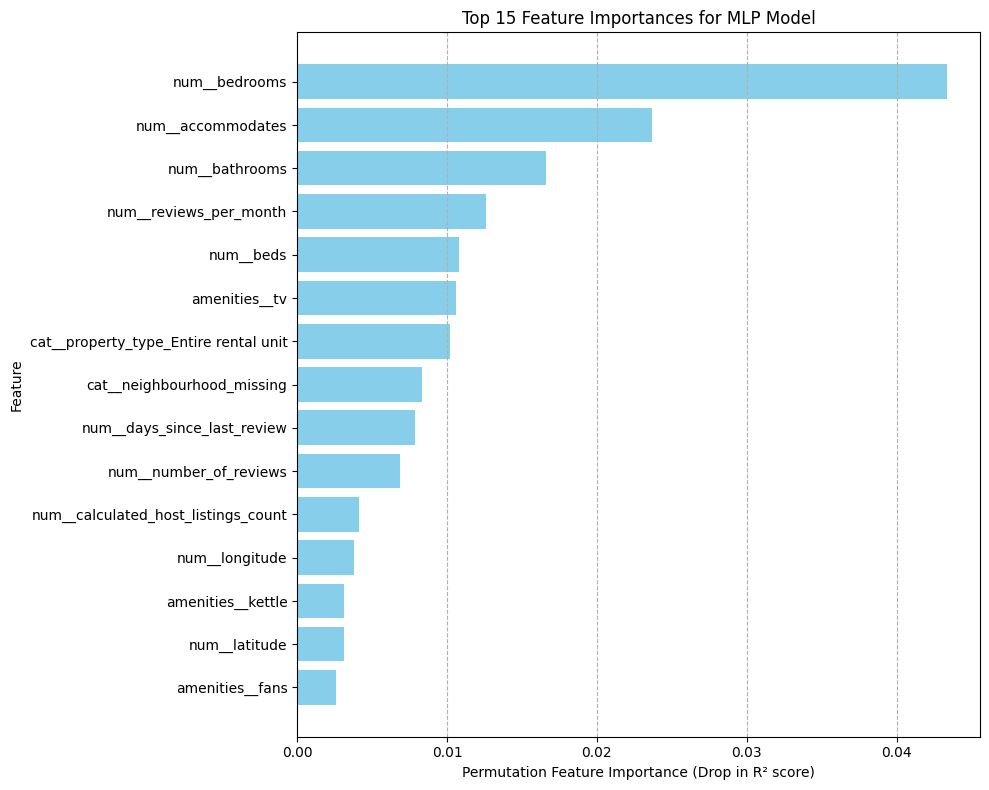

In [16]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Transform the test data using the fitted pipeline's preprocessor ---
X_test_transformed = pipe.named_steps['preprocess'].transform(X_test)

# --- 2. Isolate the trained regressor from the pipeline ---
mlp_regressor = pipe.named_steps['regressor']

# --- 3. Calculate Permutation Importance on the TRANSFORMED data ---
print("Calculating permutation importance on transformed data...")
perm_importance = permutation_importance(
    mlp_regressor, # Use the isolated regressor
    X_test_transformed, # Use the transformed data
    y_test_log,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
print("...Done!")

# --- 4. Get the transformed feature names ---
# This will now match the shape of the importance results
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()

# --- 5. Create the feature_importance DataFrame ---
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# --- 6. Create the feature importance bar plot ---
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)

plt.barh(y=top_features['feature'], width=top_features['importance'], color='skyblue')
plt.xlabel('Permutation Feature Importance (Drop in R² score)')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances for MLP Model')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()